In [1]:
from math import *
import numpy as np
import pandas as pd
import csv
import matplotlib.pyplot as plt

Nodeと面は違う  
温度はNodeごとに定義するんじゃない？じゃあ、Nodeの中にいくつかの面が取り込まれる方式になるはず、いやこれも違う、Nodeは面と独立,　面は方向を持つけど、それぞれの面がどのノードに属しているかの情報が必要  
Node間の関係はグラフ理論のやつ使ったらえんかな、データ構造的に工夫して格納しても良いけど  
Environmentはどうしよ、全体として  

熱源：外部は，熱入力、その方向を持つ  
    内部はSCが持って、熱入力、どのノードか？ これはまたあとで

基本的に熱平衡方程式は各ノード間、

各面に対するノードidは面の定義のときに入力させる

外部熱入力に関してメモ：

In [69]:
#dfで与える．
#phys_propはNodeでまとめて与えることにした．そのほうが良い
class Component:
    def __init__(self, name, area_prop):
        self.node_num = area_prop.iat[-1,0] - area_prop.iat[0,0] + 1
        self.name = name
        self.surface = self.ini_surface(area_prop)

    #このノード数の追加いるかな？最初から入れとけばよくね？
    def ini_surface(self, area_prop):
        node_num = []
        for row in area_prop.itertuples():
            node_num.append(row.end_node-row.begin_node+1)
        area_prop["node_num"] = node_num
        direction = [(1,0,0), (0,1,0), (0,0,1), (-1,0,0), (0,-1,0), (0,0,-1)] #PX,PY,PZ,MX,MY,MZの順
        area_prop["direction"] = direction
        return area_prop

#compo_list = [MISSION, BUS, PANEL]

#view prop以外はpandas
class Spacecraft:
    def __init__(self, Cij, in_out, view_prop, phys_prop, compo_list):
        self.node_number = 0 #ini_nodeで統合
        self.conductance = Cij
        self.compo_relation = in_out
        self.view_factor = view_prop
        self.compos = {i.name : i for i in compo_list}
        #self.size = size #sizeは小さい順に入力
        #self.node_id = list(surface_name_id.values())
        self.node = phys_prop
        self.ini_node()

    def ini_node(self): 
        Compos = []
        for name,compo in self.compos.items():
            Compos.append(name)
            self.node_number = self.node_number + compo.node_num #各コンポが持つノードを合計
        self.node["compo"] = Compos

    #時間ごとの環境変化（姿勢、熱）をアップデート
    #def update(self):
     #   self

class Environment:
    def __init__(self, node_num, flux, temperature):
        self.node_number = node_num
        self.node = []
        self.flux = flux #時間履歴とフラックス強さ，角度を格納，これもpandasにする．複数になったときのために[pandas,...]にしとこ
        self.calc_direction()
        self.ini_node(temperature)
    def ini_node(self, temperature):
        for i in range(self.node_number):
            self.node.append({"temperature[K]" : temperature[i]})

    def calc_direction(self):
        directions = []
        for i in range(len(self.flux)):
            for index, row in self.flux[i].iterrows():
                phi_rad = radians(row["phi[deg]"])
                theta_rad = radians(row["theta[deg]"])
                directions.append((sin(phi_rad)*cos(theta_rad), sin(phi_rad)*sin(theta_rad), cos(phi_rad)))
            self.flux[i]["direction"] = directions

#ノードを辞書にしとけば方程式に与える時に求めるもの以外のノードをすぐに探せるから要修正
#各ノードにすぐアクセスできてかつ全てのノード情報を持つ，
class Node:
    def __init__(self, spacecraft, environment):
        self.all = spacecraft.node + environment.node
        self.node_number = spacecraft.node_number + environment.node_number

#Space以外の全てのノードについて解くように変更する
class Thermal_equation:
    def __init__(self, SC, Env, dt, step):
        self.sc = SC
        #self.Node_i = SC.node[node_id]
        self.N = SC.node_number + Env.node_number
        self.dt = dt
        self.t = 0 #時刻
        self.step = step
        self.T = dt*step
        self.k = 0 #Runge_Kuttaの係数
        self.env = Env
        self.answer = np.empty((self.N-1, self.step)) #答え格納

    def AlphaEpsilon(self,i,j,S_i,S_j):
        compo_i = self.sc.node.at[i,"compo"]
        compo_j = self.sc.node.at[j,"compo"]
        relation = self.sc.compo_relation.at[compo_i, compo_j]
        #out-out
        if relation == 1:
            alpha_i = self.sc.compos[compo_i].surface.at[S_i,"alpha_out"]
            epsilon_i = self.sc.compos[compo_i].surface.at[S_i,"epsilon_out"]
            alpha_j = self.sc.compos[compo_j].surface.at[S_j,"alpha_out"]
            epsilon_j = self.sc.compos[compo_j].surface.at[S_j,"epsilon_out"]
        #out-in
        elif relation == 2:
            alpha_i = self.sc.compos[compo_i].surface.at[S_i,"alpha_out"]
            epsilon_i = self.sc.compos[compo_i].surface.at[S_i,"epsilon_out"]
            alpha_j = self.sc.compos[compo_j].surface.at[S_j,"alpha_in"]
            epsilon_j = self.sc.compos[compo_j].surface.at[S_j,"epsilon_in"]
        #in-out
        elif relation == 3:
            alpha_i = self.sc.compos[compo_i].surface.at[S_i,"alpha_in"]
            epsilon_i = self.sc.compos[compo_i].surface.at[S_i,"epsilon_in"]
            alpha_j = self.sc.compos[compo_j].surface.at[S_j,"alpha_out"]
            epsilon_j = self.sc.compos[compo_j].surface.at[S_j,"epsilon_out"]
        else:
            alpha_i, epsilon_i, alpha_j, epsilon_j = (0,0,0,0)
        return (alpha_i, epsilon_i, alpha_j, epsilon_j)

    def find_surface(self, k):
        compo = self.sc.node.at[k,"compo"] #compoの名前
        surfaces = []
        for surface, row in self.sc.compos[compo].surface.iterrows():
            if (k >= row["begin_node"] and k <= row["end_node"]):
                surfaces.append((surface, float(row["area"])))
        return compo, surfaces #compoの名前と[(面の名前,area),...]をタプルで返す

    def dT_dt(self, i):
        sigma = 5.67 * 10**(-8)
        trans_sum = 0
        radiation_sum = 0
        Node_i = self.sc.node.loc[i,:]
        i_surfaces = self.find_surface(i)
        capa = Node_i["weight[kg]"]*Node_i["capacity[J/K/kg]"]
        #各面について
        for S_i in i_surfaces[1]:
            i_surface = i_surfaces[0] + "_" + S_i[0]
            #どちらも一緒か試す。どっちでもええ
            Ai = S_i[1]
            #Ai = self.sc.compos[i_surfaces[0]].surface.at[S_i,"area"]
            #熱伝達と輻射量を計算
            for j in range(len(self.sc.node)):
                j = j+1 #nodeIDにあわせる
                Node_j = self.sc.node.loc[j,:]
                Rij = 0
                #indexでのアクセスはnodeID-1
                trans_sum = trans_sum + self.sc.conductance.iat[i-1,j-1]*(Node_i["temperature[K]"] + self.k - Node_j["temperature[K]"])
                #以下，熱放射を考える．
                j_surfaces = self.find_surface(j)
                #ノードが持つ各面に関しても回さないといけない…重い…
                for S_j in j_surfaces[1]:
                    alpha_i, epsilon_i, alpha_j, epsilon_j = self.AlphaEpsilon(i,j,S_i[0],S_j[0])
                    #BUS_PXのように固有の面情報を作る．view factorアクセス用, view factorは辞書
                    j_surface = j_surfaces[0] + "_" + S_j[0]
                    Fij = self.sc.view_factor[(i,i_surface)][(j,j_surface)]
                    Rij = Rij + epsilon_i*epsilon_j*Fij*Ai
                radiation_sum = radiation_sum + sigma*Rij*((Node_i["temperature[K]"] + self.k)**4 - Node_j["temperature[K]"]**4)
                #print("Rij:",Rij)
                #print(radiation_sum)
            #宇宙空間に対する放射も考える．
            Fi_space = self.sc.view_factor[(i,i_surface)][(self.N,"SPACE")]
            #ここのε違う，Spaceに対するものに変更
            epsilon_i = self.sc.compos[i_surfaces[0]].surface.at[S_i[0],"epsilon_out"]
            Ri_space = epsilon_i*1*Fi_space*Ai
            #print("Ri_space:",Ri_space)
            radiation_sum = radiation_sum + sigma*Ri_space*((Node_i["temperature[K]"] + self.k)**4 - self.env.node[0]["temperature[K]"]**4)
        #外部熱入力を計算
        #print(Node_i["temperature[K]"])
        Qin = 0
        for F in self.env.flux:
            #この時刻におけるフラックスを探す
            for index, row in F.iterrows():
                begin = row["begin_time[s]"]
                end = row["end_time[s]"]
                if (self.t >= begin) and (self.t <= end):
                    f = row
                    break
                #else:
                    #f = None
            #if (f == None):
                #break
            compo_name, Surfaces = i_surfaces
            for S in Surfaces: #各面の情報を取り出す S=(PX,area)
                alpha_i = self.sc.compos[compo_name].surface.at[S[0],"alpha_out"]
                N_direction = self.sc.compos[compo_name].surface.at[S[0],"direction"]
                f_dot_n =0 #Fluxベクトルと面の法線ベクトルの内積を初期化
                for f_d, s_d in zip(f["direction"], N_direction):
                    f_dot_n = f_dot_n + f_d*s_d #Fluxベクトルと面の法線ベクトルの内積
                if f_dot_n < 0: #内積が負のときは入力がある
                    Qin = Qin - f["flux[W/m2]"]*f_dot_n*alpha_i*S[1]
                else:
                    Qin = Qin
            #内部発熱
            q_internal = Node_i["internal_heat[W]"]
        return (Qin + q_internal - trans_sum - radiation_sum)/capa
    
    #定常
    #def Newton_method(self):    

    def Euler(self):
        Ti = np.empty(self.step)
        for i in range(self.step):
            Ti[i] = self.Node_i["temperature"]
            self.Node_i["temperature"] = self.Node_i["temperature"] + self.dT_dt()*self.dt
        return Ti

    #時間tにおける積分をまとめて行う(t+1を求める)．
    def RungeKutta4(self):
        Tt = []
        dT = 0
        #space以外で回す
        for i in range(1,self.N):
            Ti = self.sc.node.at[i,"temperature[K]"]
            k1 = self.dt*self.dT_dt(i)
            self.k = k1/2
            k2 = self.dt*self.dT_dt(i)
            self.k = k2/2
            k3 = self.dt*self.dT_dt(i)
            self.k = k3
            k4 = self.dt*self.dT_dt(i)
            dT = (k1 + 2*k2 + 2*k3 + k4)/6
            Tt.append(Ti + dT)
            self.sc.node.at[i,"temperature[K]"] = Ti + dT
        #print(dT)
        return Tt

    #この中でフラックス情報アップデート，RK4回す
    def solve(self):
        for s in range(self.step):
            self.t = self.dt*s
            self.answer[:,s] = self.RungeKutta4()
            #print(self.answer[:,s])


def Plot(ther_eq):
    answer = ther_eq.answer
    T_plot = [i*ther_eq.dt for i in range(ther_eq.step)]
    plt.xlabel("step")
    plt.ylabel("T[K]")
    for i in range(len(answer)):
        plt.plot(T_plot,answer[i,:])
    plt.savefig("../figure/T.png")

2. 初期化のためのCSVファイルをPandasで読み取る  


In [70]:
Cij = pd.read_csv('thermal_config/Cij.csv', index_col=0) #各ノードについて
mission_area = pd.read_csv('thermal_config/area_properties/MISSION.csv', index_col=0)
bus_area = pd.read_csv('thermal_config/area_properties/BUS.csv', index_col=0)
panel_area = pd.read_csv('thermal_config/area_properties/PANEL.csv', index_col=0)
in_out_prop = pd.read_csv('thermal_config/in_out_properties.csv', index_col=0)
phys_prop = pd.read_csv('thermal_config/physical_properties.csv')
phys_prop.index = phys_prop.index + 1 #nodeと一致させる
solar_flux = pd.read_csv('thermal_config/outer_flux.csv')

#view propertyだけ辞書型にする
with open('thermal_config/view_properties.csv') as f:
    reader = csv.reader(f)
    view_list = [row for row in reader]
view_key1 = [(int(i),j) for i,j in zip(view_list[0][2:],view_list[1][2:])]
view_key2 = view_key1[:-1]
view_prop = {}
for i in range(len(view_key2)):
    view_values = {}
    for j in range(len(view_key1)):
        #print(float(view_list[2+i][2+j]))
        view_values[view_key1[j]] = float(view_list[2+i][2+j])
    view_prop[view_key2[i]] = view_values
#print(view_prop)
#view_prop = pd.read_csv('thermal_config/view_properties.csv', index_col=0)
view_prop
#bus_area
#phys_prop
solar_flux

,begin_time[s],end_time[s],flux[W/m2],phi[deg],theta[deg]
0,0,200,1366,0,0
1,201,1000,1366,0,0
2,1001,100000,1366,0,0


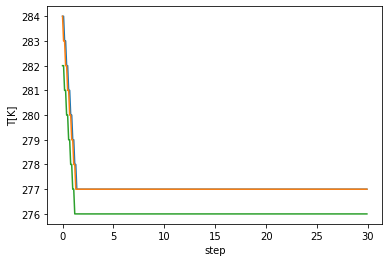

In [72]:
size = (0.10, 0.20, 0.30) #m 6U
SC_temperature = (25.0 + 273,) #K

Unv_node_num = 1
Unv_temperature = (-270 + 273,) #K

#Envにおけるheatをしっかり定義，このフラックス方向の変化刻みと伝搬における刻み幅は独立させる．
fluxes = [solar_flux]

dt = 0.1 #[s]
step = 300

MISSION = Component("MISSION", mission_area)
BUS = Component("BUS", bus_area)
PANEL = Component("PANEL", panel_area)

compo_l = [MISSION, BUS, PANEL]

SC = Spacecraft(Cij, in_out_prop, view_prop, phys_prop, compo_l)
#print(SC.node)
Env = Environment(Unv_node_num, fluxes, Unv_temperature)
#Node()
Ther_eq = Thermal_equation(SC, Env, dt, step)
Ther_eq.solve()
#print(Ther_eq.f())
Plot(Ther_eq)